In [10]:
import numpy as np

def homing_nn_q6(n_trials,learning_rate,eps,gamma,lamb):

    # Solving homing task with on-policy TD (SARSA)

    n_steps = 50

    ## Definition of the environment
    N = 3                              #height of the gridworld ---> number of rows
    M = 3                               #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)
    N_actions = 4                                           #number of possible actions in each state: 1->N 2->E 3->S 4->W
    action_row_change = np.array([-1,0,+1,0])               #number of cell shifted in vertical as a function of the action
    action_col_change = np.array([0,+1,0,-1])               #number of cell shifted in horizontal as a function of the action
    End = np.array([1, 1])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End,dims=(N,M),order='F')  #terminal state. Conversion in single index

    ## Parameters of the model
    #gamma = 0.9                        #discounting factor
    #learning_rate = 0.3                #constant step-size parameter (learning rate)
    #eps = 0.5                          #epsilon-greedy SARSA

    ## Rewards
    R = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions,N_states) #4 by 12
    #e = np.zeros((N_actions,N_states)) 
    learning_curve = np.zeros((1,n_trials))

    ## SARSA

    # Start trials
    for trial in range(n_trials):
        
        e = np.zeros((N_actions,N_states))   
        # Initialization
        #Start = np.array([2,2])
        Start = np.array([np.random.randint(N),np.random.randint(M)])   #random start
        s_start = np.ravel_multi_index(Start,dims=(N,M),order='F')      #conversion in single index
        state = Start                                                   #set current state
        start = np.array([2,2])
        s_index = s_start                                               #conversion in single index
        step = 0
        #lamb = 0.8
        # Start steps
        while s_index != s_end and step <= n_steps:

            step += 1
            learning_curve[0,trial] = step

            input_vector = states_matrix[:,s_index].reshape(N_states,1) #convert the state into an input vector 12 by 1

            #compute Qvalues. Qvalue=logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig(4(N_actions) by 1)

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action
            
            # Initialse eligibilty matrix for the first step       
            #if step ==1:
            e[action,s_index] = e[action,s_index] + 1
                
            
            state_new = np.array([0,0])
            #move into a new state
            state_new[0] = state[0] + action_row_change[action]
            state_new[1] = state[1] + action_col_change[action]

            #put the robot back in grid if it goes out. Consider also the option to give a negative reward
            if state_new[0] < 0:
                state_new[0] = 0
            if state_new[0] >= N:
                state_new[0] = N-1
            if state_new[1] < 0:
                state_new[1] = 0
            if state_new[1] >= M:
                state_new[1] = M-1

            s_index_new = np.ravel_multi_index(state_new,dims=(N,M),order='F')  #conversion in a single index
            
            
            ## TODO update Qvalues. Only if is not the first step
            if step > 1:
                # Update weights
                dw = learning_rate * (r_old - Q_old + gamma * Q[action])*e
                weights += dw
                
            e = gamma*lamb*e
            
            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions,1))
            output[action] = 1
            r_old = 0
            
            #update variables
            Q_old = Q[action]
            
            state[0] = state_new[0]
            state[1] = state_new[1]
            s_index = s_index_new
            
            ## TODO: check if state is terminal and update the weights consequently
            if s_index == s_end:
                        
                # Update weights for the terminal state
                dw = learning_rate * (R - Q_old) *e
                weights += dw             
            else:
                pass
    
    return e

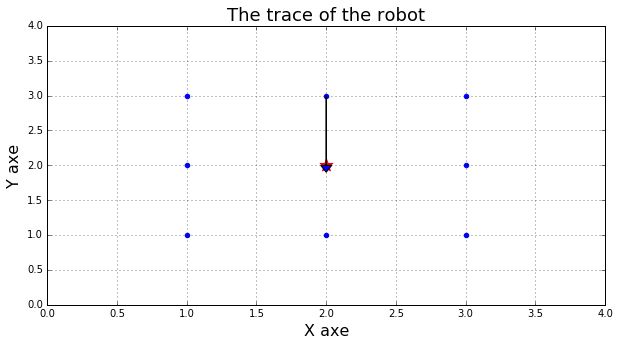

In [67]:
##plot average learning curve##
#%matplotib inline
# Initialise parameters
import matplotlib.pyplot as plt
%matplotlib inline

N = 3
M=3
n_trials = 500
eps = 0
gamma = 0.9                                     #curve full down very quickly when applying high gamma 
learning_rate = 0.9
repetitions = 10
lamb = 0.9

dy = np.array([+1,0,-1,0])               #number of cell shifted in vertical as a function of the action
dx = np.array([0,+1,0,-1])

#ax = plt.axes(figsize(10,5))
fig, ax = plt.subplots(figsize=(10,5))
e_index = homing_nn_q6(n_trials,learning_rate,eps,gamma,lamb)

#find the nonzero parameters in Eligibility matrix
for i in range(N):
    for j in range(M):
        e_ravel = np.array([i,j])
        e_index_ravel = np.ravel_multi_index(e_ravel,dims=(N,M),order='F')#transform the current state to ravel model
        #ax.scatter(N+1,M+1,s=40,color='b',marker='o')
        for k in range(4):
            if e_index[k,e_index_ravel] !=0:#search the nonzero one in k_th column of the new ravel matrix
                #print(i,j)
                ax.arrow(j+1,N-i, dx[k], dy[k],head_width=0.08, head_length=0.1)#plot arrows
#plot        
for m in range(3):
    for n in range(3):

        ax.scatter(m+1,n+1,s=20,color='b',marker='o')

ax.scatter(2,2,s=180,color='r',marker='*')
ax.set_xlabel('X axe',fontsize=16)
ax.set_ylabel('Y axe',fontsize=16)
ax.set_title('The trace of the robot',fontsize=18)
plt.xlim([0,M+1])
plt.ylim([0,M+1])
plt.grid(True)
plt.show()
